## Essential Libraries

In [1]:
!pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.4 MB/s eta 0:00:00


In [2]:
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

tfds.disable_progress_bar()

Using TensorFlow backend


## Hyperparameter setup

In [3]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameter
UNLABELED_BATCH_SIZE = 1024
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
PROJECTION_WIDTH = 128
TEMPERATURE = 0.1

# Stronger augmentations for contrastive
CONTRASTIVE_AUGMENTATION = {
    "crop_area_factor": (0.08, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.8,
    "brightness_factor": 0.2,
    "contrast_factor": 0.8,
    "saturation_factor": (0.3, 0.7),
    "hue_factor": 0.2,
}

# Weaker ones for supervised training
CLASSIFICATION_AUGMENTATION = {
    "crop_area_factor": (0.8, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.05,
    "brightness_factor": 0.1,
    "contrast_factor": 0.1,
    "saturation_factor": (0.1, 0.1),
    "hue_factor": 0.2,
}

AUTOTUNE = tf.data.AUTOTUNE

## Dataset

The dataset has three splits:
- Training Unlabelled: This dataset is used to train the encoder in the contrastive setting.
- Training Lablelled: This dataset is used to train the baseline encoder (supervised) and also
    fine tune the pre-trained encoder.
- Testing Labelled: This dataset is used to evaluate the models.

In [4]:

def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="unlabelled", as_supervised=True)
        .map(lambda image, _: image, num_parallel_calls=AUTOTUNE)
        .shuffle(buffer_size=2 * UNLABELED_BATCH_SIZE)
        .batch(UNLABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
        .shuffle(buffer_size=10 * LABELED_BATCH_SIZE)
        .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    test_dataset = (
        tfds.load("stl10", data_dir="dataset", split="test", as_supervised=True)
        .batch(TEST_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

Dataset stl10 downloaded and prepared to dataset/stl10/1.0.0. Subsequent calls will reuse this data.


## Image augmentations


In [5]:
def get_augmenter(
    crop_area_factor,
    aspect_ratio_factor,
    color_jitter_rate,
    brightness_factor,
    contrast_factor,
    saturation_factor,
    hue_factor,
):
    return keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
            keras_cv.layers.Rescaling(scale=1.0 / 255),
            keras_cv.layers.RandomFlip("horizontal"),
            keras_cv.layers.RandomCropAndResize(
                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                crop_area_factor=crop_area_factor,
                aspect_ratio_factor=aspect_ratio_factor,
            ),
            keras_cv.layers.RandomApply(
                keras_cv.layers.RandomColorJitter(
                    value_range=(0, 1),
                    brightness_factor=brightness_factor,
                    contrast_factor=contrast_factor,
                    saturation_factor=saturation_factor,
                    hue_factor=hue_factor,
                ),
                rate=color_jitter_rate,
            ),
        ]
    )


## Visualize the dataset

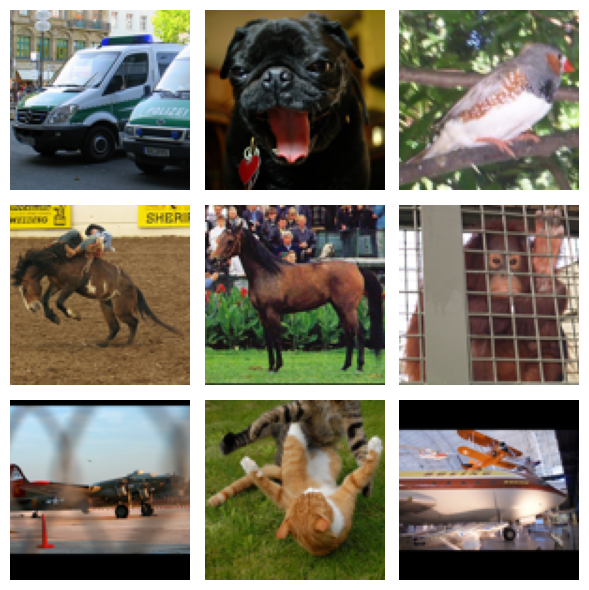

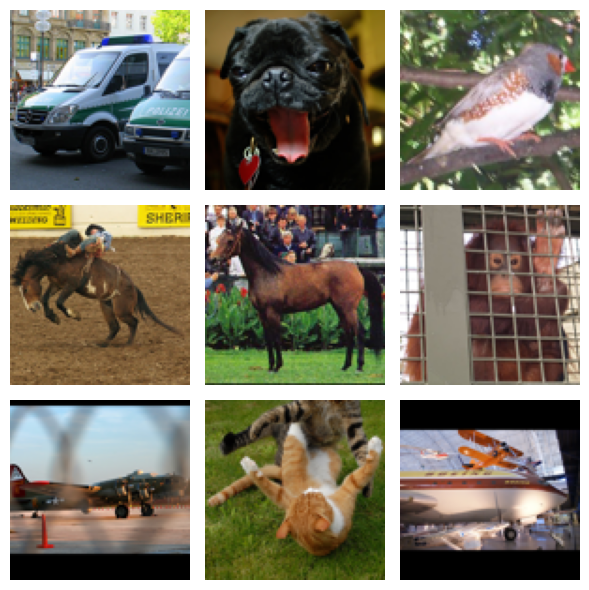

In [6]:
# Original Images
unlabeled_images = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images=unlabeled_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

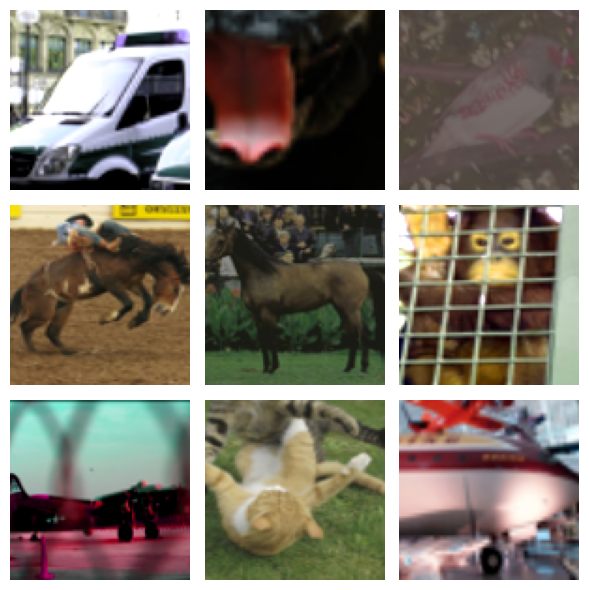

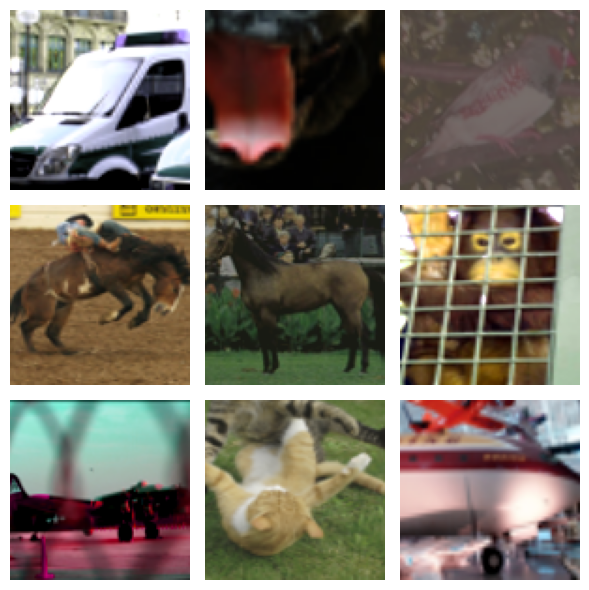

In [7]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

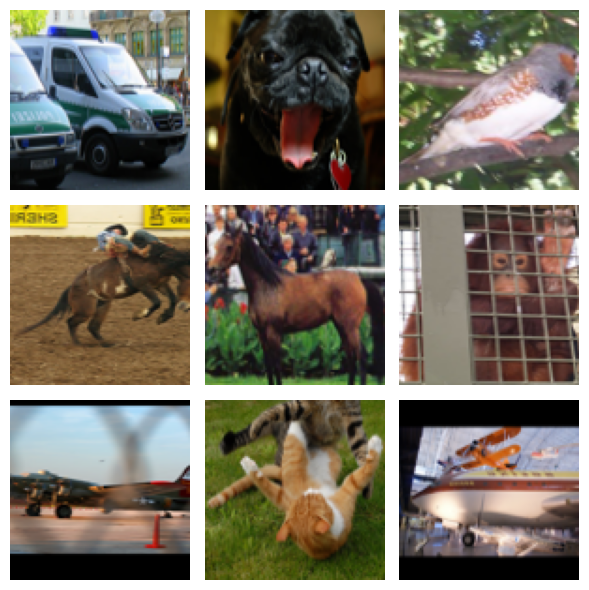

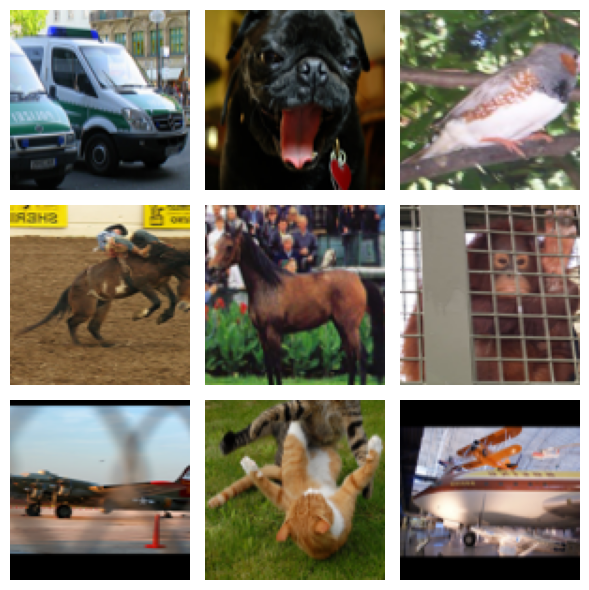

In [8]:
# Classification Augmentations
classification_augmenter = get_augmenter(**CLASSIFICATION_AUGMENTATION)
augmented_images = classification_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

## Encoder architecture

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
            keras_cv.models.ResNet18Backbone(include_rescaling=False),
            keras.layers.GlobalAveragePooling2D(name="avg_pool"),
        ],
        name="encoder",
    )


## Supervised baseline model


In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        get_encoder(),
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


40/40 [==============================] - ETA: 0s - loss: 1.8697 - acc: 0.3170

40/40 [==============================] - 513s 13s/step - loss: 1.8697 - acc: 0.3170 - val_loss: 5.6937 - val_acc: 0.1437
Epoch 2/20
40/40 [==============================] - 508s 13s/step - loss: 1.4629 - acc: 0.4514 - val_loss: 4.9874 - val_acc: 0.1076
Epoch 3/20
40/40 [==============================] - 505s 13s/step - loss: 1.3269 - acc: 0.5128 - val_loss: 5.6334 - val_acc: 0.1000
Epoch 4/20
40/40 [==============================] - 505s 13s/step - loss: 1.2609 - acc: 0.5314 - val_loss: 3.3762 - val_acc: 0.1084
Epoch 5/20
40/40 [==============================] - 502s 13s/step - loss: 1.1781 - acc: 0.5748 - val_loss: 8.1555 - val_acc: 0.1001
Epoch 6/20
40/40 [==============================] - 502s 13s/step - loss: 1.1829 - acc: 0.5728 - val_loss: 2.5301 - val_acc: 0.2081
Epoch 7/20
40/40 [==============================] - 502s 13s/step - loss: 1.0716 - acc: 0.6172 - val_loss: 3.3985 - val_acc: 0.1852
Epoch 8/20
40/40 [==============================] - 502s 13s/step - loss: 1.0141 - acc:

## Self-supervised model for contrastive pretraining


## Supervised finetuning of the pretrained encoder


In [16]:
# Supervised finetuning of the pretrained encoder
finetune_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        simclr_model.encoder,
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="finetuning_model",
)
finetune_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetune_history = finetune_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetune_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


40/40 [==============================] - ETA: 0s - loss: 1.9466 - acc: 0.3296

40/40 [==============================] - 518s 13s/step - loss: 1.9466 - acc: 0.3296 - val_loss: 3.7093 - val_acc: 0.1324
Epoch 2/20
40/40 [==============================] - 507s 13s/step - loss: 1.4983 - acc: 0.4432 - val_loss: 5.1031 - val_acc: 0.1020
Epoch 3/20
40/40 [==============================] - 503s 13s/step - loss: 1.3606 - acc: 0.4990 - val_loss: 4.3802 - val_acc: 0.1222
Epoch 4/20
40/40 [==============================] - 493s 12s/step - loss: 1.2647 - acc: 0.5284 - val_loss: 3.5435 - val_acc: 0.1651
Epoch 5/20
40/40 [==============================] - 506s 13s/step - loss: 1.2760 - acc: 0.5402 - val_loss: 3.6033 - val_acc: 0.1546
Epoch 6/20
40/40 [==============================] - 506s 13s/step - loss: 1.1447 - acc: 0.5868 - val_loss: 2.7998 - val_acc: 0.2164
Epoch 7/20
40/40 [==============================] - 505s 13s/step - loss: 1.0030 - acc: 0.6306 - val_loss: 2.5440 - val_acc: 0.2499
Epoch 8/20
40/40 [==============================] - 491s 12s/step - loss: 0.9918 - acc:

## Comparison against the baseline

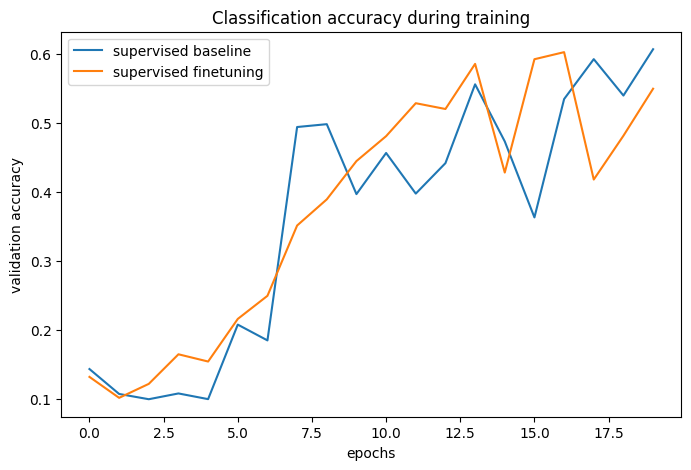

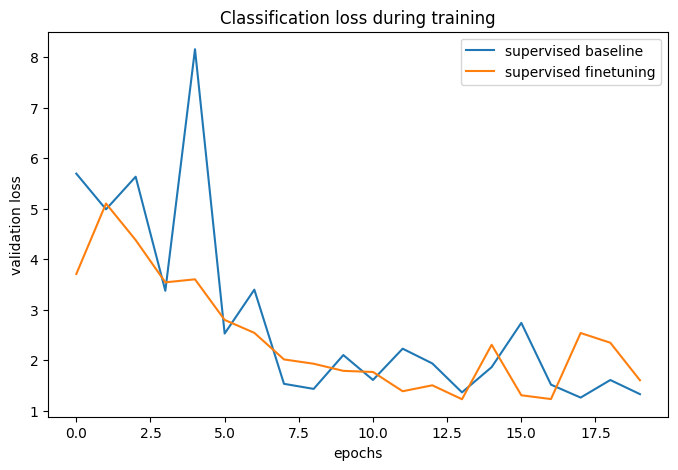

In [18]:

# The classification accuracies of the baseline and finetuning process:
def plot_training_curves(baseline_history, finetune_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            finetune_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(baseline_history, finetune_history)